# Liverpool ion switching: Permutation importance for feature selection ~part 1~

Feature engineering and feature selection are the one of the important & difficult task for kaggler to improve model performance.

Here I will introduce **permutation importance and model's feature importance ("gain" and "split") using LightGBM**. I think these are useful for feature selection.

If you don't know about permutation importance, please refer Machine Learning Explainability Home Page [Permutation importance](https://www.kaggle.com/dansbecker/permutation-importance).
It can be computed **after model is trained** (thus no additional training is necessary for calculating importance), by **randomly permuting one column's feature** for inference to see the effect on prediction value.
![](https://i.imgur.com/h17tMUU.png)
*Figures from [Permutation importance](https://www.kaggle.com/dansbecker/permutation-importance)

# Table of Contents

**1. [Load data](#id1)**<br/>
**2. [Clean drift](#id2)**<br/>
**3. [Preprocessing: feature engineering](#id3)**<br/>
**4. [Util functions for calculating model/permutation importance](#id4)**<br/>
**5. [Training a model with GroupKFold cross validation](#id5)**<br/>
**6. [Visualizing feature importance & permutation importance](#id55)**<br/>
**7. [Prediction on test data](#id6)**<br/>
**8. [References and further reading](#id7)**<br/>

If you are only interested in the code to calculate permutation importance, jump to [Util functions for calculating model/permutation importance](#id4).<br/>
If you are only interested in the visualization & observation of feature importance, jump to [Visualizing feature importance & permutation importance](#id55).<br/>

In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)


In [2]:
from contextlib import contextmanager
from time import perf_counter


@contextmanager
def timer(name):
    t0 = perf_counter()
    yield
    t1 = perf_counter()
    print('[{}] done in {:.3f} s'.format(name, t1-t0))

Very fast macro f1 score calculation methods.
Refer [Fast macro f1 computation](https://www.kaggle.com/corochann/fast-macro-f1-computation) for details.

In [3]:
import numba as nb


def macro_f1_score(y_true, y_pred, n_labels):
    total_f1 = 0.
    for i in range(n_labels):
        yt = y_true == i
        yp = y_pred == i

        tp = np.sum(yt & yp)

        tpfp = np.sum(yp)
        tpfn = np.sum(yt)
        if tpfp == 0:
            print('[WARNING] F-score is ill-defined and being set to 0.0 in labels with no predicted samples.')
            precision = 0.
        else:
            precision = tp / tpfp
        if tpfn == 0:
            print(f'[ERROR] label not found in y_true...')
            recall = 0.
        else:
            recall = tp / tpfn

        if precision == 0. or recall == 0.:
            f1 = 0.
        else:
            f1 = 2 * precision * recall / (precision + recall)
        total_f1 += f1
    return total_f1 / n_labels


macro_f1_score_nb = nb.jit(nb.float64(nb.int32[:], nb.int32[:], nb.int64), nopython=True, nogil=True)(macro_f1_score)

<a id="id1"></a><br>
# Load data

I use [Liverpool ion switching feather](https://www.kaggle.com/corochann/liverpool-ion-switching-feather) dataset to load the data much faster. You can also refer the kernel [Convert to feather format for fast data loading](https://www.kaggle.com/corochann/convert-to-feather-format-for-fast-data-loading).

In [4]:
%%time
datadir = Path('/kaggle/input/liverpool-ion-switching-feather')

train = pd.read_feather(datadir/'train.feather')
test = pd.read_feather(datadir/'test.feather')
submission = pd.read_feather(datadir/'sample_submission.feather')

CPU times: user 113 ms, sys: 239 ms, total: 352 ms
Wall time: 480 ms


In [5]:
signal_array = train['signal'].values
open_channels = train['open_channels'].values

test_signal_array = test['signal'].values

In [6]:
# --- configurations ---

debug = False
arch = 'lgb'
outdir = Path('.')

<a id="id2"></a><br>
# Clean drift

Please refer the discussion [What is Drift?](https://www.kaggle.com/c/liverpool-ion-switching/discussion/133874) and the kernel [One Feature Model Scores LB 0.930!](https://www.kaggle.com/cdeotte/one-feature-model-0-930) by @cdeotte for details.

As you can see in the below figures, signal contains baseline shift and it is called "drift". The method for manually removing drift is introduced in the above kernel.

In [7]:
"""
Manually clean drift.
Plot all train/test data.
Ref https://www.kaggle.com/cdeotte/one-feature-model-0-930 by @cdeotte
"""


def clean_train(train):
    def f(x, low, high, mid):
        return -((-low + high) / 625) * (x - mid) ** 2 + high - low

    # CLEAN TRAIN BATCH 2
    a = 500000
    b = 600000
    train.loc[train.index[a:b], 'signal'] = train.signal[a:b].values - 3 * (train.time.values[a:b] - 50) / 10.

    # CLEAN TRAIN BATCH 7
    batch = 7
    a = 500000 * (batch - 1)
    b = 500000 * batch
    train.loc[train.index[a:b], 'signal'] = train.signal.values[a:b] - f(train.time[a:b].values, -1.817, 3.186, 325)
    # CLEAN TRAIN BATCH 8
    batch = 8
    a = 500000 * (batch - 1)
    b = 500000 * batch
    train.loc[train.index[a:b], 'signal'] = train.signal.values[a:b] - f(train.time[a:b].values, -0.094, 4.936, 375)
    # CLEAN TRAIN BATCH 9
    batch = 9
    a = 500000 * (batch - 1)
    b = 500000 * batch
    train.loc[train.index[a:b], 'signal'] = train.signal.values[a:b] - f(train.time[a:b].values, 1.715, 6.689, 425)
    # CLEAN TRAIN BATCH 10
    batch = 10
    a = 500000 * (batch - 1)
    b = 500000 * batch
    train.loc[train.index[a:b], 'signal'] = train.signal.values[a:b] - f(train.time[a:b].values, 3.361, 8.45, 475)
    return train


def clean_test(test):
    # REMOVE BATCH 1 DRIFT
    start = 500
    a = 0
    b = 100000
    test.loc[test.index[a:b], 'signal'] = test.signal.values[a:b] - 3 * (test.time.values[a:b] - start) / 10.
    start = 510
    a = 100000
    b = 200000
    test.loc[test.index[a:b], 'signal'] = test.signal.values[a:b] - 3 * (test.time.values[a:b] - start) / 10.
    start = 540
    a = 400000
    b = 500000
    test.loc[test.index[a:b], 'signal'] = test.signal.values[a:b] - 3 * (test.time.values[a:b] - start) / 10.

    # REMOVE BATCH 2 DRIFT
    start = 560
    a = 600000
    b = 700000
    test.loc[test.index[a:b], 'signal'] = test.signal.values[a:b] - 3 * (test.time.values[a:b] - start) / 10.
    start = 570
    a = 700000
    b = 800000
    test.loc[test.index[a:b], 'signal'] = test.signal.values[a:b] - 3 * (test.time.values[a:b] - start) / 10.
    start = 580
    a = 800000
    b = 900000
    test.loc[test.index[a:b], 'signal'] = test.signal.values[a:b] - 3 * (test.time.values[a:b] - start) / 10.

    # REMOVE BATCH 3 DRIFT
    def f(x):
        return -(0.00788) * (x - 625) ** 2 + 2.345 + 2.58

    a = 1000000
    b = 1500000
    test.loc[test.index[a:b], 'signal'] = test.signal.values[a:b] - f(test.time[a:b].values)
    return test


def plot_all_train_signal(train, title):
    plt.figure(figsize=(20,5)); res = 1000
    plt.plot(range(0,train.shape[0],res),train.signal[0::res])
    for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
    for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
    plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
    plt.title(title,size=20)
    plt.show()

    
def plot_all_test_signal(test, title):
    let = ['A','B','C','D','E','F','G','H','I','J']
    plt.figure(figsize=(20,5))
    res = 1000
    plt.plot(range(0,test.shape[0],res),test.signal[0::res])
    for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
    for i in range(21): plt.plot([i*100000,i*100000],[-5,12.5],'r:')
    for k in range(4): plt.text(k*500000+250000,10,str(k+1),size=20)
    for k in range(10): plt.text(k*100000+40000,7.5,let[k],size=16)
    plt.title(title,size=20)
    plt.show()

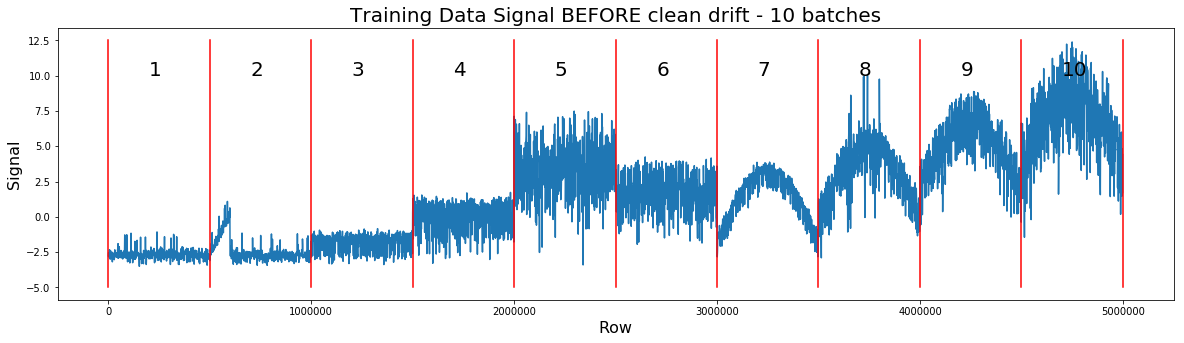

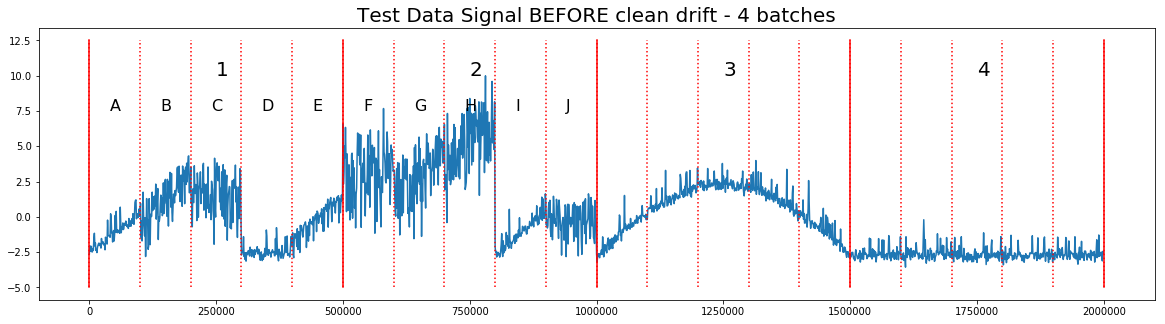

In [8]:
plot_all_train_signal(train, title='Training Data Signal BEFORE clean drift - 10 batches')
plot_all_test_signal(test, title='Test Data Signal BEFORE clean drift - 4 batches')

Let's apply it to see the behavior, the drift is removed and each batch mean value is now horizontally straight line.

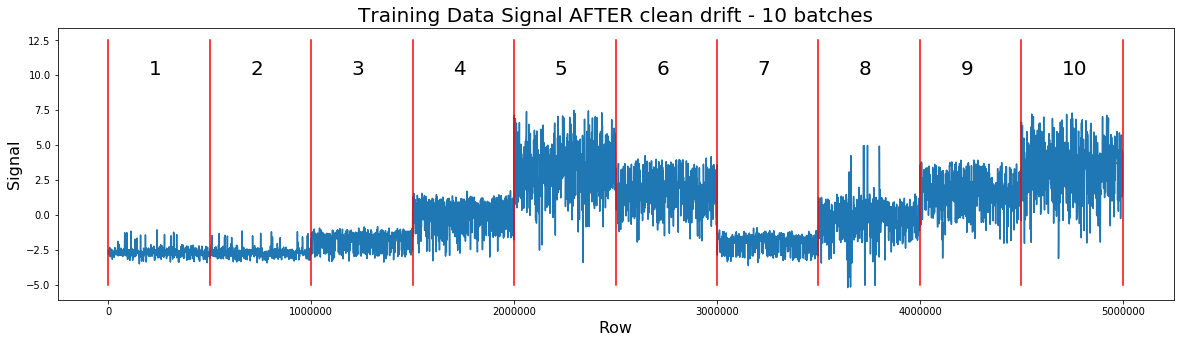

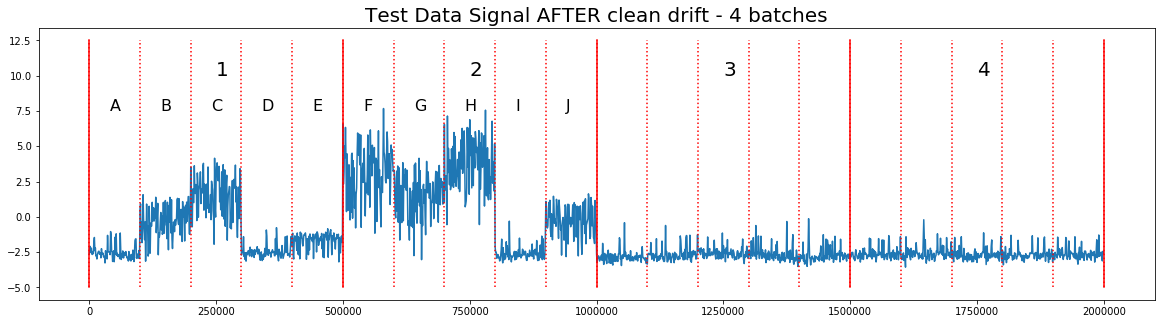

In [9]:
train = clean_train(train)
test = clean_test(test)

plot_all_train_signal(train, title='Training Data Signal AFTER clean drift - 10 batches')
plot_all_test_signal(test, title='Test Data Signal AFTER clean drift - 4 batches')

<a id="id3"></a><br>
# Preprocessing: feature engineering



In [10]:
if debug:
    s = 500000*4
    train = train.iloc[s:s+50000]
    test = test.iloc[:1000]
    submission = submission.iloc[:1000]

The util method for smoothing to calculate baseline. I wrote a separate kernel [Liverpool ion switching: smoothing visualization](https://www.kaggle.com/corochann/liverpool-ion-switching-smoothing-visualization) to explain how smoothing works.

In [11]:
from scipy import signal


def filter_wave(x, cutoff=(-1, -1), N=4, filtering='lfilter'):
    """Apply low pass/high pass/band pass filter on wave `x`

    Args:
        x (numpy.ndarray): original wave array.
        cutoff (tuple): tuple of 2 int.
            1st element is for lowest frequency to pass. -1 indicates to allow freq=0
            2nd element is for highest frequency to pass. -1 indicates to allow freq=infty
        N (int): order of filter
        filtering (str): filtering method. `lfilter` or `filtfilt` method.

    Returns:
        filtered_x (numpy.ndarray): same shape with `x`, filter applied.
    """
    assert x.ndim == 1
    output = 'sos' if filtering == 'sos' else 'ba'
    if cutoff[0] <= 0 and cutoff[1] <= 0:
        # Do not apply filter
        return x
    elif cutoff[0] <= 0 and cutoff[1] > 0:
        # Apply low pass filter
        output = signal.butter(N, Wn=cutoff[1]/len(x), btype='lowpass', output=output)
    elif cutoff[0] > 0 and cutoff[1] <= 0:
        # Apply high pass filter
        output = signal.butter(N, Wn=cutoff[0]/len(x), btype='highpass', output=output)
    else:
        # Apply band pass filter
        output = signal.butter(N, Wn=(cutoff[0]/len(x), cutoff[1]/len(x)), btype='bandpass', output=output)

    if filtering == 'lfilter':
        b, a = output
        return signal.lfilter(b, a, x)
    elif filtering == 'filtfilt':
        b, a = output
        return signal.filtfilt(b, a, x)
    elif filtering == 'sos':
        sos = output
        return signal.sosfilt(sos, x)
    else:
        raise ValueError("[ERROR] Unexpected value filtering={}".format(filtering))

Features originally inspired from [Ion Switching - 5kfold LGBM & Tracking](https://www.kaggle.com/robikscube/ion-switching-5kfold-lgbm-tracking) by @robikscube.

But I changed the following:

 - Make batch window slice length as variables
 - Take aggregated stats feature by `pd.rolling`, instead of making batch. (It takes time to compute though...)
 - Separate preprocessing window for index with signal jumped place
 - Added "XXX_mbase" feature, this is "signal feature - baseline" feature where baseline is calculated by smoothing function

In [12]:
train_separate_indices = [
    0, 500_000, 600_000, 1_000000, 1_500000, 2_000000, 2_500000,
    3_000000, 3_500000, 4_000000, 4_500000, 5_000000]
test_separate_indices = [
    0, 100_000, 200_000, 300_000, 400_000, 500_000, 600_000, 700_000,
    800_000, 900_000, 1_000000, 1_500000, 2_000000]


def _create_total_batch_indices(separate_indices):
    s = separate_indices
    total_batch = np.zeros((s[-1],), dtype=np.int64)
    for i in range(len(s) - 1):
        total_batch[s[i]:s[i+1]] = i
    return total_batch


def create_total_batch_indices(train: bool = True):
    separate_indices = train_separate_indices if train else test_separate_indices
    return _create_total_batch_indices(separate_indices)


class Preprocessor(object):
    """Features ispired from: https://www.kaggle.com/robikscube/ion-switching-5kfold-lgbm-tracking"""

    def __init__(self, feature_cols=None, debug=False, use_sep=True):
        self.feature_cols = feature_cols
        self.debug = debug
        self.use_sep = use_sep
        # window_list = [5000, 50000]
        self.window_list = [5000, 10000, 50000]

    def preprocess(self, tt, train=True):
        feature_cols = self.feature_cols
        window_list = self.window_list

        window_str = '-'.join(list(map(str, window_list)))
        cache_path = f'pp_tt_train{int(train)}_debug{int(self.debug)}_usesep{int(self.use_sep)}_w{window_str}.feather'

        # --- default feature cols ---
        msignal_cols = []
        # 5000, 50_000 Batch Features
        for window in window_list:
            msignal_cols.extend([
                f'signal_batch_{window}_min', f'signal_batch_{window}_max',
                f'signal_batch_{window}_std', f'signal_batch_{window}_mean',
                f'mean_abs_chg_batch_{window}',
                f'abs_max_batch_{window}', f'abs_min_batch_{window}',
                f'range_batch_{window}', f'maxtomin_batch_{window}', f'abs_avg_batch_{window}'
            ])
        msignal_cols.extend([
            'signal_shift+1', 'signal_shift-1',
            'signal_shift+2', 'signal_shift-2'])
        default_feature_cols = ['signal', 'baseline']
        default_feature_cols.extend(msignal_cols)
        default_feature_cols.extend([f'{c}_msignal' for c in msignal_cols])
        default_feature_cols.extend([f'{c}_mbase' for c in msignal_cols])
        # --- default feature cols end ---

        if not os.path.exists(cache_path):
            tt = tt.sort_values(by=['time']).reset_index(drop=True)
            tt.index = ((tt.time * 10_000) - 1).values
            if self.use_sep:
                separate_indices = train_separate_indices if train else test_separate_indices
                separate_indices = separate_indices[:len(tt)]
                tt['total_batch'] = create_total_batch_indices(train=train)[:len(tt)]
            else:
                raise NotImplementedError()
                separate_indices = None
                tt['total_batch'] = tt.index // 500_000
            tt['batch'] = tt.index // 50_000
            tt['batch_index'] = tt.index - (tt.batch * 50_000)
            tt['batch_slices'] = tt['batch_index'] // 5_000
            tt['batch_slices2'] = tt.apply(lambda r: '_'.join(
                [str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)

            # Calculate baseline
            cutoff_high = 100
            signal = tt['signal'].values
            total_batch = tt['total_batch'].values

            smooth_fn = lambda x: filter_wave(x, cutoff=(0, cutoff_high), filtering='filtfilt')
            baseline = np.concatenate([smooth_fn(signal[separate_indices[k]:separate_indices[k+1]])
                                       for k in range(total_batch[-1] + 1)])
            tt['baseline'] = baseline

            # 5000, 50_000 Batch Features
            for window in window_list:
                rolling_df = tt.groupby('total_batch')['signal'].rolling(
                    window=window, min_periods=1, center=True)
                tt[f'signal_batch_{window}_min'] = rolling_df.min().values
                tt[f'signal_batch_{window}_max'] = rolling_df.max().values
                tt[f'signal_batch_{window}_std'] = rolling_df.std().values
                tt[f'signal_batch_{window}_mean'] = rolling_df.mean().values
                tt[f'mean_abs_chg_batch_{window}'] = rolling_df.apply(
                    lambda x: np.mean(np.abs(np.diff(x))), raw=True).values
                tt[f'abs_max_batch_{window}'] = rolling_df.apply(
                    lambda x: np.max(np.abs(x)), raw=True).values
                tt[f'abs_min_batch_{window}'] = rolling_df.apply(
                    lambda x: np.min(np.abs(x)), raw=True).values

                tt[f'range_batch_{window}'] = \
                    tt[f'signal_batch_{window}_max'] - tt[f'signal_batch_{window}_min']
                # It makes nan when min=0.
                tt[f'maxtomin_batch_{window}'] = \
                    tt[f'signal_batch_{window}_max'] / tt[f'signal_batch_{window}_min']
                tt[f'abs_avg_batch_{window}'] = \
                    (tt[f'abs_min_batch_{window}'] + tt[f'abs_max_batch_{window}']) / 2

            # add shifts
            # NOTE: nan is not allowed to use permutation importance...
            tt['signal_shift+1'] = tt.groupby(['batch']).shift(1, fill_value=0.)['signal']
            tt['signal_shift-1'] = tt.groupby(['batch']).shift(-1, fill_value=0.)['signal']
            tt['signal_shift+2'] = tt.groupby(['batch']).shift(2, fill_value=0.)['signal']
            tt['signal_shift-2'] = tt.groupby(['batch']).shift(-2, fill_value=0.)['signal']

            for c in msignal_cols:
                tt[f'{c}_msignal'] = tt[c] - tt['signal']
            for c in msignal_cols:
                tt[f'{c}_mbase'] = tt[c] - tt['baseline']

            tt = tt.replace([np.inf, -np.inf], np.nan)
            print('Number of nan', tt.isna().sum().sum())
            tt.fillna(-1, inplace=True)
            print(f'saving to {cache_path}')
            #tt.reset_index(drop=True).to_feather(cache_path)
        else:
            print(f'loading from {cache_path}')
            tt = pd.read_feather(cache_path)

        if feature_cols is None:
            feature_cols = default_feature_cols

        X_train = tt[feature_cols]
        if train:
            y_train = tt['open_channels'].values
        else:
            y_train = None
        return X_train, y_train


In [13]:
pp = Preprocessor(debug=debug)

with timer('preprocess train'):
    X_train, y_train = pp.preprocess(train)

Number of nan 0
saving to pp_tt_train1_debug0_usesep1_w5000-10000-50000.feather
[preprocess train] done in 2027.840 s


<a id="id4"></a><br>
# Util functions for calculating model/permutation importance

## Model feature importance

LightGBM model has `feature_importance` method which calculates each feature's importance. Here I just made some util methods to summarize it in `DataFrame` format and plot it.

In [14]:
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()


## Permutation importance

`eli5` library provides `PermutationImportance` class to calculate permutation importance.<br/>
It assumes sklearn API, and thus **`fit` and `score` method need to be implemented in the `model` to calc permutation importance**.

Here I made `LGBWrapper` class, which wraps LightGBM model to add the `fit` and `score` methods so that permutation importance can be calculated with LightGBM model.<br/>
`score` function is implemented to calculate Macro F1 score so that it can calculate the permutation importance for this competition's evaluation metric.

In [15]:
from eli5.sklearn import PermutationImportance


class F1MacroScorerWrapper(object):
    """Base class"""
    def fit(self, X, y):
        print('F1MacroScorerWrapper fit called!')

    def predict(self, X):
        raise NotImplementedError()

    def score(self, X, y):
        y_pred = self.predict(X)
        y_pred_valid_int = np.round(np.clip(y_pred, 0, 10))
        macro_f1 = macro_f1_score_nb(y.astype(np.int32), y_pred_valid_int.astype(np.int32), 10)
        return macro_f1

    
class LGBWrapper(F1MacroScorerWrapper):
    def __init__(self, lgb_model):
        self.lgb_model = lgb_model

    def predict(self, X):
        return self.lgb_model.predict(X, num_iteration=self.lgb_model.best_iteration)

    def feature_importance(self, **kwargs):
        return self.lgb_model.feature_importance(**kwargs)


def calc_permutation_importance(model, valid_data, feature_names=None):
    """Calculates permutation importance

    Args:
        model: `score` method should be implemented to calc score used to calc permutation importance.
            `fit` method should exist, eli5 library assumes sklearn API and
            `fit` method existence is checked (though the method itself is not used).
        valid_data: data used to calc perm importance.
        feature_names: feature names, it is used to construct data frame.

    Returns:
        perm (PermutationImportance): eli5 object
        perm_importance_df (pd.DataFrame):
    """
    perm = PermutationImportance(
        model, random_state=1, cv='prefit').fit(*valid_data)
    perm_importance_df = pd.DataFrame({
        'importance': perm.feature_importances_
    }, index=feature_names).sort_values('importance', ascending=True)
    return perm, perm_importance_df

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version o

<a id="id5"></a><br>
# Training a model with GroupKFold cross validation

In [16]:
def fit_lgb(train, val, devices=(-1,), seed=None, cat_features=None,
            num_rounds=1500, lr=0.1):
    """Train Light GBM model

    Ref: https://www.kaggle.com/corochann/ashrae-training-lgbm-by-meter-type
    """
    X_train, y_train = train
    X_valid, y_valid = val

    # https://www.kaggle.com/pestipeti/eda-ion-switching
    metric = 'l1'
    params = {'num_leaves': 128,
              'min_data_in_leaf': 64,
              'objective': 'huber',
              'max_depth': -1,
              'learning_rate': lr,  # 0.005,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": 0.8,
              "bagging_seed": 11,
              "metric": metric,
              "verbosity": -1,
              'reg_alpha': 0.1,
              'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)

    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training'][metric],
           'valid/mae': model.best_score['valid_1'][metric]}
    return model, y_pred_valid, log

What is the proper CV in this competition? Since this is time-series data, randomly shuffling & splitting all data may cause overfitting to the training data.
The ideal way is to separate by measurement batch, for each 500000 points. However the label `open_channels=10` is contained only limited batch and this separation is too difficult to learn the label with few or no training data.

Here I took the intermediate option. Signal is separated each 100000 steps, to obtain consective field as different batch.

In [17]:
from sklearn.model_selection import KFold, GroupKFold

# --- cross validation ---
folds = 5
seed = 666
cv_method = 'groupkfold'
if cv_method == 'groupkfold':
    group_batch_width = 500000
    if debug:
        groups = np.arange(folds).repeat(len(train) // folds)
    else:
        groups = np.tile(
            np.arange(folds).repeat(group_batch_width // folds), 10)
    kf = GroupKFold(n_splits=folds)
    cv_iter = kf.split(X_train, y_train, groups=groups)
else:
    raise ValueError("[ERROR] Unexpected value cv_method={}"
                     .format(cv_method))

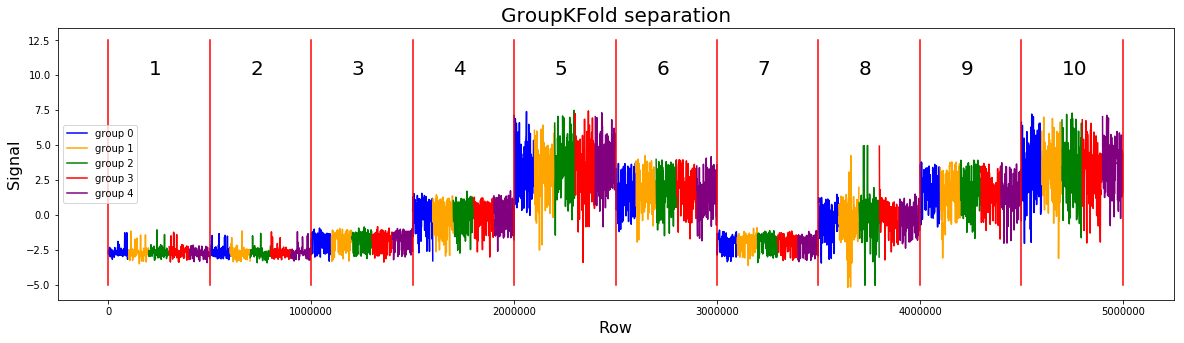

In [18]:
# visualize group
plt.figure(figsize=(20,5))
res = 1000

x_idx = np.arange(train.shape[0])

color_list = ['blue', 'orange', 'green', 'red', 'purple']
current_idx = 0
one_batch_width = group_batch_width // folds
while current_idx * one_batch_width < len(train):
    group_idx = groups[current_idx * one_batch_width]
    col = color_list[group_idx]
    sl = slice(current_idx * one_batch_width, (current_idx + 1 ) * one_batch_width, res)
    label = f'group {group_idx}' if current_idx < folds else ''
    plt.plot(x_idx[sl], train.signal[sl], color=col, label=label)
    current_idx += 1

for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('GroupKFold separation',size=20)
plt.legend()
plt.show()

In [19]:
calc_perm = True  # Note that it takes much long time than training!

y_valid_pred_total = np.zeros(X_train.shape[0])
models = []
log_list = []
macro_f1_list = []

gain_importance_list = []
split_importance_list = []
perm_importance_list = []
for fold_idx, (train_idx, valid_idx) in enumerate(cv_iter):
    train_data = X_train.iloc[train_idx, :], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx, :], y_train[valid_idx]

    print('fold_idx', fold_idx, 'train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgb(train_data, valid_data,
                                       num_rounds=5000, lr=0.3)
    model = LGBWrapper(model)
    print('log', log)

    y_valid_pred_total[valid_idx] = y_pred_valid
    models.append(model)

    y_true_valid = valid_data[1]
    y_pred_valid_int = np.round(np.clip(y_pred_valid, 0, 10))
    macro_f1 = macro_f1_score(y_true_valid, y_pred_valid_int, 10)
    print('macro_f1', macro_f1)
    log['fold_idx'] = fold_idx
    log['macro_f1'] = macro_f1
    log_list.append(log)
    macro_f1_list.append(macro_f1)

    # --- calc model feature importance ---
    feature_names = train_data[0].columns.tolist()
    gain_importance_df = calc_model_importance(
        model, feature_names=feature_names, importance_type='gain')
    gain_importance_list.append(gain_importance_df)

    split_importance_df = calc_model_importance(
        model, feature_names=feature_names, importance_type='split')
    split_importance_list.append(split_importance_df)

    # --- calc permutation importance ---
    if calc_perm:
        print('calculating permutation importance...')
        if (debug and fold_idx == 0) or not debug:
            with timer('calc_permutation_importance'):
                perm, perm_importance_df = calc_permutation_importance(
                    model, valid_data, feature_names=feature_names)
            perm_importance_list.append(perm_importance_df)

    gc.collect()

fold_idx 0 train 4000000 valid 1000000
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l1: 0.0923445	valid_1's l1: 0.0958422
[40]	training's l1: 0.0499963	valid_1's l1: 0.054055
Early stopping, best iteration is:
[38]	training's l1: 0.0499519	valid_1's l1: 0.0540159
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l1', 0.049951882944502736)]), 'valid_1': OrderedDict([('l1', 0.05401586722901651)])})
log {'train/mae': 0.049951882944502736, 'valid/mae': 0.05401586722901651}
macro_f1 0.9390390589208794
calculating permutation importance...
[calc_permutation_importance] done in 3359.780 s
fold_idx 1 train 4000000 valid 1000000
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l1: 0.092721	valid_1's l1: 0.0914818
[40]	training's l1: 0.0502795	valid_1's l1: 0.0498658
Early stopping, best iteration is:
[35]	training's l1: 0.0504604	valid_1's l1: 0.0497909
best_score defaultd

Check trained performance

In [20]:
log_df = pd.DataFrame(log_list)
log_df.to_csv(outdir/'log.csv', index=False)
logmean_df = log_df.mean(axis=0)
logmean_df.to_csv(outdir/'log_mean.csv')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.



In [21]:
logmean_df

train/mae    0.049574
valid/mae    0.054672
fold_idx     2.000000
macro_f1     0.938782
dtype: float64

<a id="id55"></a><br>
# Visualizing feature importance & permutation importance

Now we got 3 types of feature importance, for each fold in CV.

 - LightGBM Model feature importance by "gain"
 - LightGBM Model feature importance by "split"
 - LightGBM Model's permutation importance

I will calulate mean of feature importance to get final result.

In [22]:
def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

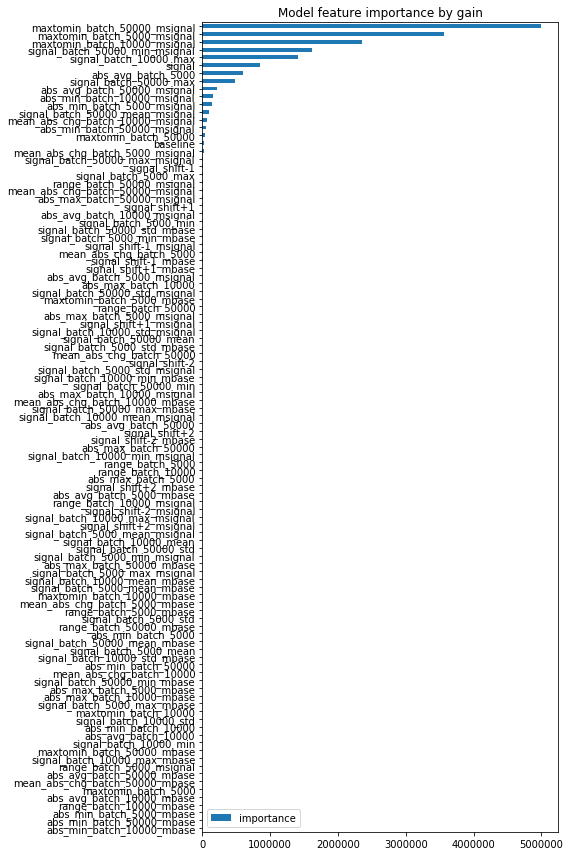

In [23]:
mean_gain_df = calc_mean_importance(gain_importance_list)
plot_importance(mean_gain_df, title='Model feature importance by gain')
mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
mean_gain_df.to_csv(outdir / 'gain_importance_mean.csv', index=False)

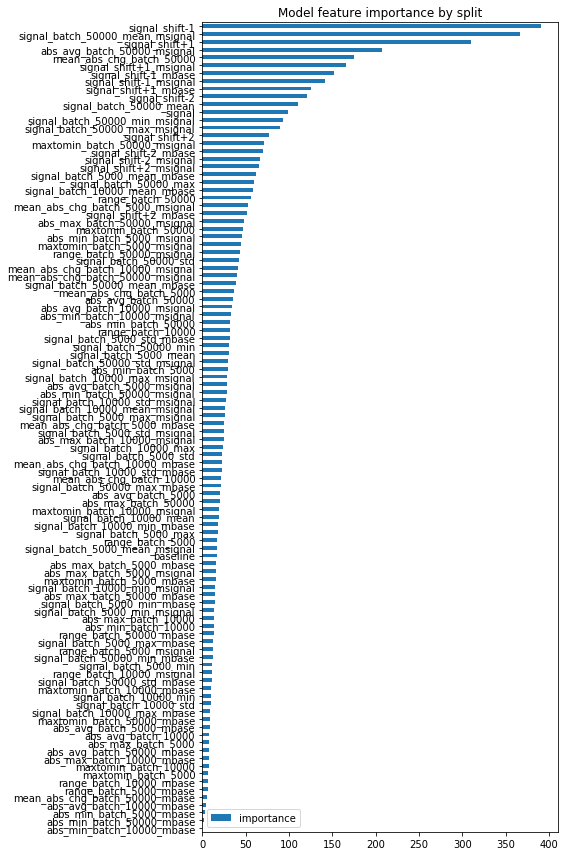

In [24]:
mean_split_df = calc_mean_importance(split_importance_list)
plot_importance(mean_split_df, title='Model feature importance by split')
mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
mean_split_df.to_csv(outdir / 'split_importance_mean.csv', index=False)

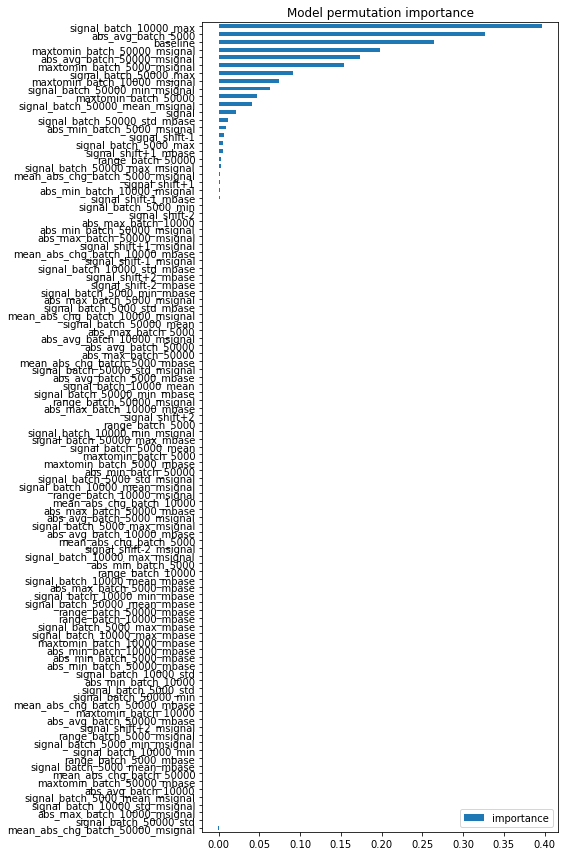

In [25]:
if calc_perm:
    mean_perm_df = calc_mean_importance(perm_importance_list)
    plot_importance(mean_perm_df, title='Model permutation importance')
    mean_perm_df = mean_perm_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_perm_df.to_csv(outdir / 'perm_importance_mean.csv', index=False)

When we compare these 3 figures, we can see following:

 - "split" importance ranges to almost all features, which means LightGBM model uses all features in their tree.
 - However, "gain" and "permutation" importance ranges to only aroud 1/4 of features. It means that even though all features are used in tree construction, many features do not contribute to improve the accuracy so much.
   - These features may be removed without sacrifycing accuracy, or even it contributes to reduce overfitting.
 - When comparing "gain" importance and "permutation" importance, its ranking is actually different. "gain" importance is high with maxtomin features, while "permutation" is high with signal_max, abs_avg, baseline, maxtomin features...

<a id="id6"></a><br>
# Prediction on test data

In [26]:
def plot_signal_and_pred(signal_array, pred, gt=None, save_filepath=None,
                         smooth_fn=None, label='smooth signal',
                         target_indices=None, interval=50, debug=False):
    if debug:
        width = len(signal_array)
    else:
        width = 500000
    if target_indices is None:
        n_batch = len(signal_array) // width
        target_indices = np.arange(n_batch)

    n_figs = len(target_indices)
    fig, axes = plt.subplots(n_figs, 1, figsize=(18, 5 * n_figs))
    for i in target_indices:
        ax = axes if n_figs == 1 else axes[i]
        s = 500000 * i
        y = signal_array[s:s + width][::interval]
        t = pred[s:s + width][::interval]
        ax.plot(y, label='signal', zorder=1)
        if smooth_fn is not None:
            y2 = smooth_fn(signal_array[s:s + width])[::interval]
            ax.plot(y2, label=label, zorder=1)
        if gt is not None:
            ax.scatter(x=np.arange(t.shape[0]), y=gt[s:s + width][::interval],
                       color='orange', label='ground truth', zorder=2)
        ax.scatter(x=np.arange(t.shape[0]), y=t, color='green', label='pred', zorder=2)
        ax.legend()
        ax.set_title(f'prediction of batch={target_indices[i]}')
    plt.tight_layout()
    if save_filepath:
        plt.savefig(save_filepath)
    else:
        plt.show()
    plt.close()


In [27]:
y_valid_pred_total_int = np.round(np.clip(y_valid_pred_total, 0, 10))
macro_f1 = macro_f1_score(y_train, y_valid_pred_total_int, 10)
print('Total CV: macro_f1', macro_f1, 'macro_f1_list', macro_f1_list)

Total CV: macro_f1 0.9387872629818623 macro_f1_list [0.9390390589208794, 0.9417711278257315, 0.9396712493530371, 0.9339953255577551, 0.9394342269959953]


In [28]:
# --- model prediction for test data ---
print('start model prediction...')
with timer('preprocess test'):
    X_test, _ = pp.preprocess(test, train=False)

y_test_pred_total = np.zeros(X_test.shape[0])
for i, model in enumerate(models):
    print(f'predicting {i}-th model')
    y_pred_test = model.predict(X_test)
    y_test_pred_total += y_pred_test
y_test_pred_total /= len(models)
y_test_pred_total_int = np.round(np.clip(y_test_pred_total, 0, 10))

start model prediction...
Number of nan 0
saving to pp_tt_train0_debug0_usesep1_w5000-10000-50000.feather
[preprocess test] done in 775.506 s
predicting 0-th model
predicting 1-th model
predicting 2-th model
predicting 3-th model
predicting 4-th model


In [29]:
# --- Save submission ---
submission['open_channels'] = y_test_pred_total_int.astype(np.int64)
submission.to_csv(outdir / 'submission.csv', index=False, float_format='%.4f')

# --- Save prediction for future ensemble, optimize threshold etc ---
np.savez_compressed(
    outdir / 'pred.npz',
    valid=y_valid_pred_total, test=y_test_pred_total)


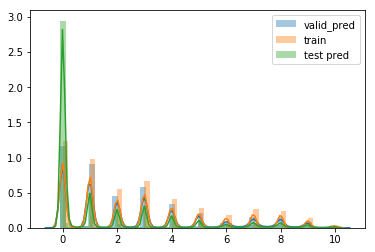

In [30]:
# --- plot dist ---
ax = sns.distplot(y_valid_pred_total, label='valid_pred')
sns.distplot(y_train, ax=ax, label='train')
sns.distplot(y_test_pred_total, ax=ax, label='test pred')
plt.legend()
plt.show()
#plt.savefig(outdir / f'dist_total_test.png')

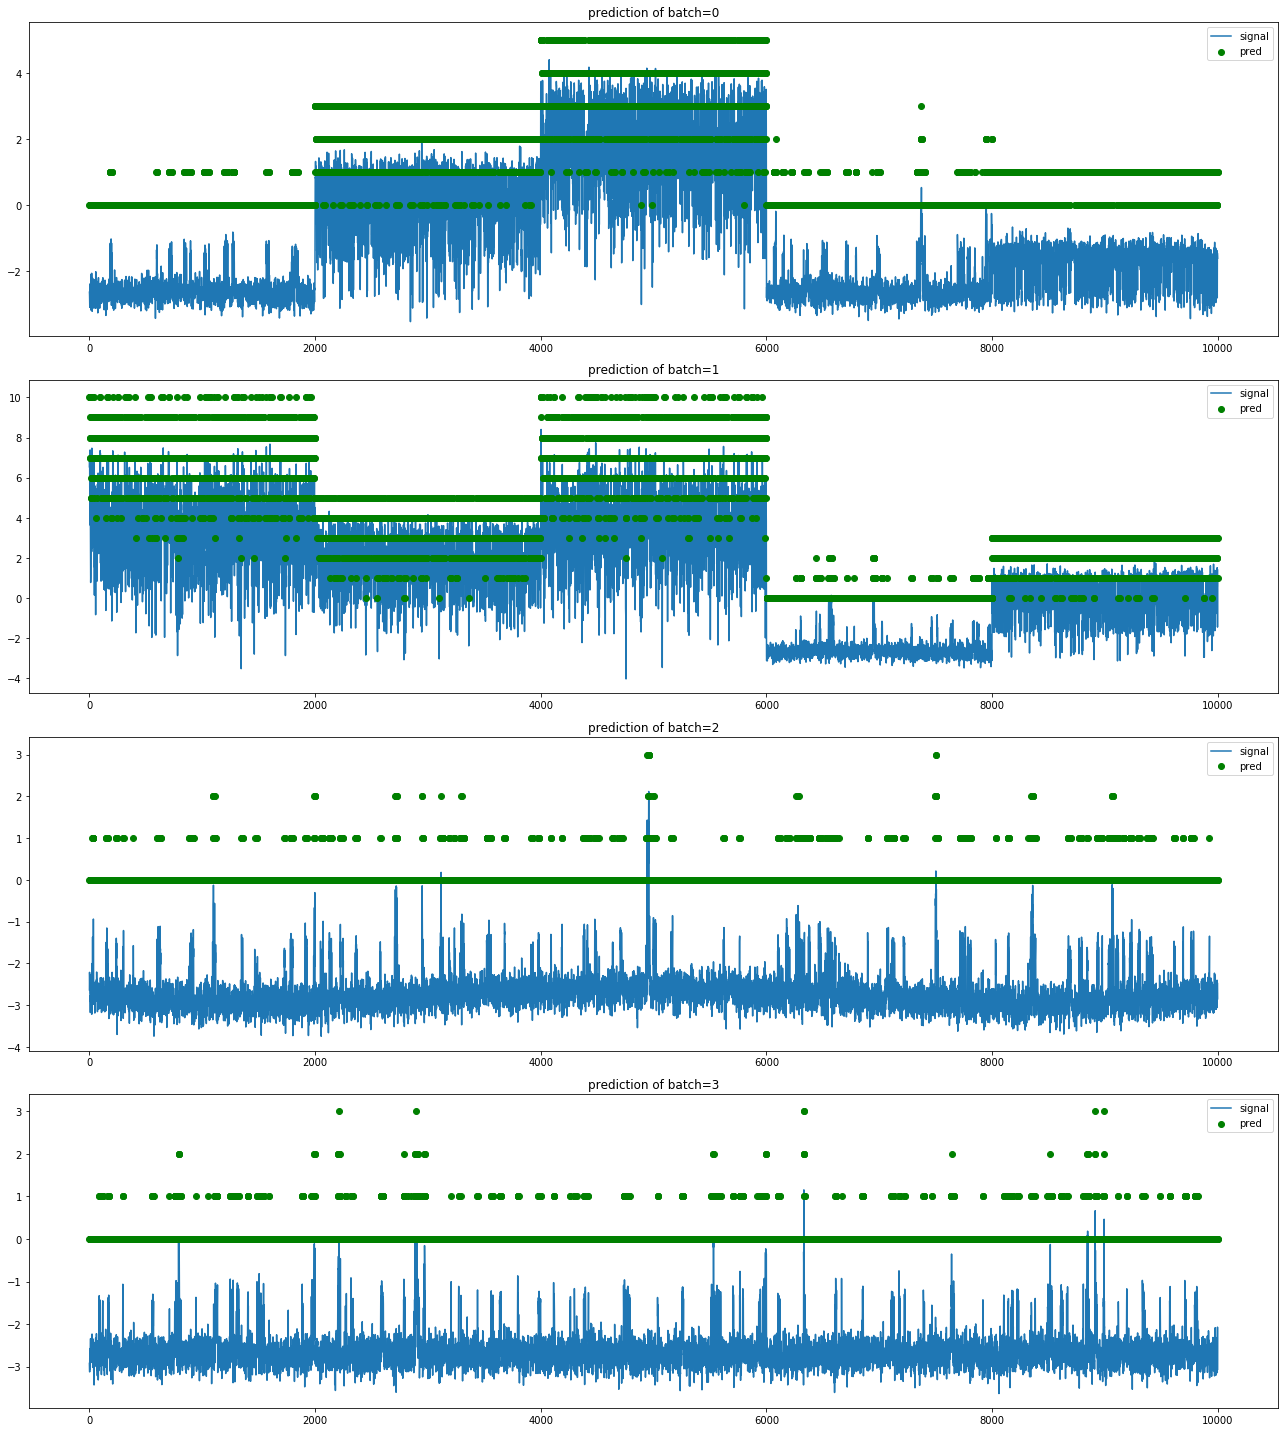

In [31]:
# --- plot prediction ---
plot_signal_and_pred(test['signal'].values, y_test_pred_total_int,
                     debug=debug)

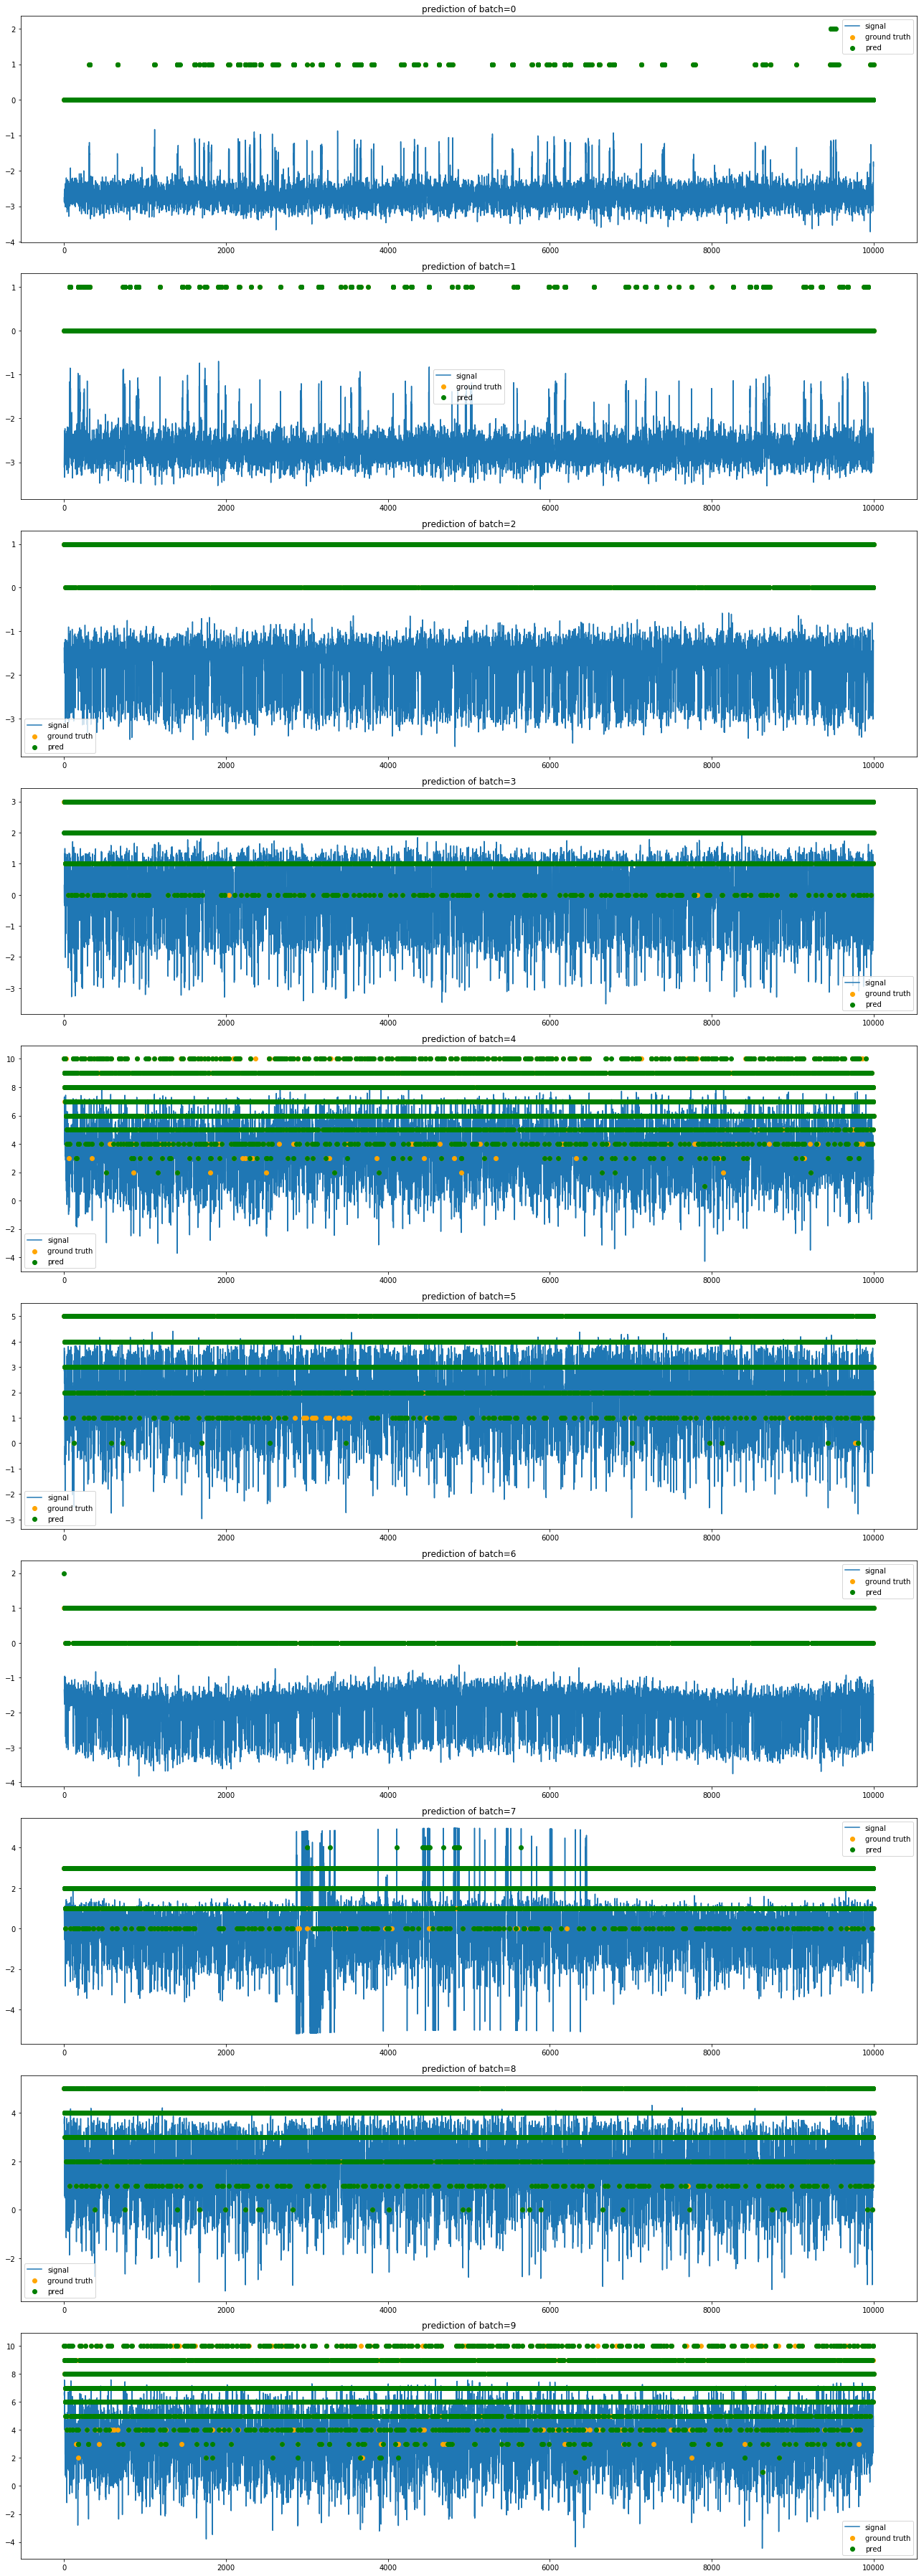

In [32]:
plot_signal_and_pred(train['signal'].values, y_valid_pred_total_int,
                     gt=train['open_channels'].values,
                     debug=debug)

<a id="id7"></a><br>
# References and further reading

That's all! You can go these references for further reading.


Discussion:
 - [What is Drift?](https://www.kaggle.com/c/liverpool-ion-switching/discussion/133874) 
 
Kernel:
 - Machine Learning Explainability Home Page [Permutation importance](https://www.kaggle.com/dansbecker/permutation-importance)
 - [One Feature Model Scores LB 0.930!](https://www.kaggle.com/cdeotte/one-feature-model-0-930)
 - [Ion Switching - 5kfold LGBM & Tracking](https://www.kaggle.com/robikscube/ion-switching-5kfold-lgbm-tracking)
 - [Convert to feather format for fast data loading](https://www.kaggle.com/corochann/convert-to-feather-format-for-fast-data-loading).
 - [Fast macro f1 computation](https://www.kaggle.com/corochann/fast-macro-f1-computation)